# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



# Содержание

<a href='#1'> Создание класса

<a href='#2' > DATA
    
<a href='#3' > EDA and Data Preprocessing
    
<a href='#4' > Feature Engineering

# import

In [381]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer # Для кодирования Cuisine Style в dummy-переменные
from sklearn import preprocessing # Для нормализации


# Инструмены для ML и расчета MAE
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


import warnings
warnings.filterwarnings('ignore') # Потому, что...

In [382]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [383]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

<a id='1'> <a/>
# Создание класса

In [384]:
class TadRating():
    '''
    Класс для анализа и создания новых признаков учебного дата.
    
    По сути это просто хранилище функций, с помощью которых происходит обработка данных.
    Разделен на 2 часть. Первая часть - анализ и обработка (замена Nan), 
    вторая часть это создание новых признаков.
    
    Доступные методы и их краткое описание:
    'city_info' - информация о колонке City
    'city_to_pop'- создание признака Население города
    'cuisine_fill_null' - заполнение пропущенных значений в колоке Cuisine Style
    'cuisine_info'- информация о колонке Cuisine Style
    'draw_bp' - рисование графиков относительно ключевой переменной
    'new_feat_city'    ]
    'new_feat_cuisine' ]} создание новых признаков на основе колонок, соотвественно
    'new_feat_ranking' ]
    'new_feat_reviews' ]
    'num_of_reviews_info' - информация о колонке Number of reviews
    'per_city_mean' - создание признака среднее количество отзывов в городе
    'per_none' - процент пропусков в исходном датасете (визуализация)
    'price_range_info' - информация о колонке Price Range
    'ranking_info' -  информация о колонке Ranking
    'repair_num_of_reviews' - удалеение пропущеных значений в признаке Number of reviews
    'repair_price_range' - удалеение пропущеных значений в признаке Price Range
    'reviews_info' - информация о Reviews
    'reviews_to_date - достать дату из текста отзывов
    
    
    '''
    
    def __init__(self, dataframe):
        self.dat = dataframe
        
        
    # Методы анализа и очистки данных ########################   
    
    def per_none(self):
        ''' 
        Метод который считает процент пропусков в датасете 
        и рисует график распределения пропусков (Название столбца - процент пропусков)
        '''
        # Считаем процент пропусков
        per_of_skips = pd.DataFrame(1-self.dat.count()/self.dat.shape[0]).reset_index().rename({0: 'percent'}, axis=1)
        per_of_skips = per_of_skips.sort_values('percent', ascending=False).query('percent>0')

        # Визуализация пропусков
        fig = plt.figure(figsize = [10,12])
        plt.subplot(211)
        bar_plot = sns.barplot(x='percent', y='index', data=per_of_skips, alpha=0.8, ci=None)
        for ytick in bar_plot.get_yticks():
            if per_of_skips.iloc[ytick][1]>0:
                bar_plot.text(per_of_skips.iloc[ytick][1]+0.0125, ytick, str(round(per_of_skips.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black', weight='semibold')
        plt.title('Относительное количество пропусков')
        plt.xlabel('Процент', fontsize=12)
        plt.ylabel('Название колонки', fontsize=12)

        plt.subplot(212)
        sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
        plt.title('Распределение пропусков по датасету')
        
        
    def city_info(self):
        ''' 
        Метод показывающий информацию по колонке City.
        Выводит информацию обуникальных городах, количество ресторанов по городам
        '''
        
        print(self.dat['City'].value_counts(ascending=False))
        print('##########################################')
        print('Всего городов в датасете представлено - {}'.format(len(self.dat['City'].value_counts(ascending=True))))
        print('##########################################')
        # График 
        plt.rcParams['figure.figsize'] = (10, 10)
        self.dat['City'].value_counts(ascending=True).plot(kind='barh')
        plt.gca().set_xlabel('Количество ресторанов', fontsize=18)
        plt.gca().set_ylabel('Город', fontsize=18)
        plt.title("Распределение количества ресторанов по городам", fontsize=20)
        plt.grid(linestyle='--', alpha=0.7)
        
        
        
    def draw_bp(self, column, reg:bool=False):
        ''' 
        Метод для отрисовки боклсплота для конкретного признака
        по целевой переменной Rating.
        '''

        fig = plt.figure(figsize = [25,10])
        plt.subplot(211)

        sns.boxplot(x=column, y='Rating', data=self.dat)
        plt.title('Боксплот для ' + column)

        if reg == True:

            a = sns.jointplot(x=column, y='Rating', data=self.dat, kind='reg')
            a.fig.suptitle('График корреляции целевой переменной с признаком')

            print('Корреляция целевой переменной с признаком')
            print((self.dat[['Rating', column]]).corr())
        
        
    def cuisine_info(self):
        
        ''' 
        Метод показывающий информацию по колонке Cuisine Style.
        Выводит информацию о видах кухни представленых их количестве
        Неизвестные кухни заменяет на Unknown        
        
        '''
        
            
        def clean_name(str_val):
 
            '''
            Преобразует строку с названиями кухонь в список [list] названий кухонь.
            На входе:
                - строковая переменная, содержащая названия кухонь.
            На выходе:
                - список [list] названий кухонь.
            '''
            if pd.isna(str_val): return ["Unknown"]
            str_val = str_val.strip('[]') # Отбрасываем скобки.
            str_val = str_val.replace("\'",'') # Убираем кавычки '.
            str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
            return str_val
        
        print(self.dat['Cuisine Style'].describe())
        print('##########################################')
        print('Пустых значений - {}'.format(self.dat['Cuisine Style'].isna().value_counts().min()))
        print('##########################################')
        
        
        self.dat['Cuisine Style'] = self.dat['Cuisine Style'].apply(clean_name)
        dft = self.dat['Cuisine Style'].explode() # Для подсчета всех кухонь в датасете
        print ('Всего в датасете представлено {} кухонь'.format(len(dft.value_counts())-1))      
        print ('##########################################')
        print ('Пустые значения переименованы в "Unknown"\n',
               '##### Топ типов кухонь в ресторанах ###### \n',dft.value_counts(), sep='')
        
    def cuisine_fill_null(self):
        '''
        Метод заменяет неизвестные значия кухонь на список "European" и "Vegetarian Friendly"
        '''
        self.dat['Cuisine Style'] = self.dat.loc[:, ('Cuisine Style')].apply(lambda x: ['European', 'Vegetarian Friendly'] 
                                                                   if x == ['Unknown'] else x)
        print(self.dat.info())
        
    def price_range_info(self):
        ''' 
        Метод показывает информацию о колонке Price Range
        '''
        print(self.dat['Price Range'].describe())
        print('##########################################')
        print(self.dat['Price Range'].explode().value_counts())
        print('##########################################')
        print('Пустых значений - {}'.format(self.dat['Price Range'].isna().sum()))
    
    def repair_price_range(self):
        ''' 
        Метод который заполняет пропущенные значения в колонке Price Range 
        на средний ценовой сигмент.
        А также превращает Price Range - порядковый категориальный признак
        '''
        self.dat['Price Range'] = self.dat['Price Range'].fillna('$$ - $$$')
        
        cleanup_price ={'Price Range': {'$':1, '$$ - $$$':2, '$$$$':3 }}
        self.dat.replace(cleanup_price, inplace=True)
        
        plt.rcParams['figure.figsize'] = (10, 10)
        self.dat['Price Range'].value_counts(ascending=True).plot(kind='barh')
        plt.gca().set_xlabel('Количество ресторанов', fontsize=18)
        plt.gca().set_ylabel('Ценовой сигмент', fontsize=18)
        plt.title("Распределение количества ресторанов по ценам", fontsize=20)
        plt.grid(linestyle='--', alpha=0.7)
        
        print(self.dat.info())
        
    def num_of_reviews_info(self):
        '''
        Метод показывает информацию о колонке Number of Reviews
        '''
        
        print('Пустых значений - {}'.format(self.dat['Number of Reviews'].isna().sum()))
        
        plt.rcParams['figure.figsize'] = (15, 12)
        self.dat.groupby(['City', 'Pop'])['Number of Reviews'].max().sort_values(ascending=True).plot(kind='barh')
        plt.gca().set_xlabel('Макисмальное количество отзывов', fontsize=18)
        plt.gca().set_ylabel('Город', fontsize=18)
        plt.title("Распределение максимального количества отзывов по городам", fontsize=20)
        plt.grid(linestyle='--', alpha=0.7)
        
        
    def repair_num_of_reviews(self):
        '''
        Метод для замены отсуствующих значений в колонке Number of Reviews 
        на значение 0, только в тех случаях когда отсуствуюет сам текст отзывов
        
        '''
                
        print ('Количество пропусков до замены - {}'.format(self.dat['Number of Reviews'].isna().sum()))
         
        for index in self.dat.loc[self.dat['Number of Reviews'].isna() == True].index:
            if (len(self.dat.loc[self.dat['Number of Reviews'].isna() == True].loc[index][6])) <=8:# 8символов пустой отзыв 
                 self.dat['Number of Reviews'].loc[index] = 0 
        print('Количество пропусков после замены - {}'.format(self.dat['Number of Reviews'].isna().sum()))
        print('##########################################')
        print('Далее замена медианой')
        median = self.dat['Number of Reviews'].median()
        self.dat['Number of Reviews'] = self.dat['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)
        print('##########################################')
        print(self.dat.info())
        
        
    def reviews_info(self):
        '''
        Метод показывает информацию о колонке Reviews
        '''
    
        summ = 0
        for rev in data['Reviews']:
            if len(rev)<=8:
                summ+=1
        print('Количество пустых значений - {} (Пустые строки, а не Nan)'.format(summ))
        
    def ranking_info(self):
        '''
        Метод показывает информацию о колонке Ranking
        '''
        fig = plt.figure(figsize = [10,12])
        axis1 = fig.add_subplot(3,1,1)
        axis2 = fig.add_subplot(312)
        axis3 = fig.add_subplot(313)


        axis1.hist(self.dat['Ranking'], bins = 100)
        axis1.set_title('Распределение признака Ranking')
        axis1.grid(linestyle='--', alpha=0.7)


        axis2.hist(self.dat['Ranking'][self.dat['City'] =='London'],bins = 100)
        axis2.set_title('Распределение признака Ranking в Лондоне')
        axis2.grid(linestyle='--', alpha=0.7)

        for x in (self.dat['City'].value_counts())[0:10].index:
                   axis3.hist(self.dat['Ranking'][self.dat['City'] == x], bins=100)
        axis3.set_title('Распределение признака Ranking в первых 10 городах')
        axis3.grid(linestyle='--', alpha=0.7)
        
        
        
    
    # Методы для создания новых признаков ##############
    

    # Новые признаки на основе City
    
    def city_to_pop(self):
        '''
        Метод для создания нового признака Pop (население)
        на основе признака City
        '''
        
        # Словарь значений численности населения
        pop = {'London': 8_908_081,
               'Paris':2_148_327,
               'Madrid': 3_266_126,
               'Barcelona': 1_664_182,
               'Berlin': 3_644_826,
               'Milan': 1_378_689,
               'Rome': 2_870_500,
               'Prague': 1_301_132,
               'Lisbon': 505_526,
               'Vienna': 1_897_491, 
               'Amsterdam': 872_757,
               'Brussels': 179_277, 
               'Hamburg': 1_841_179,
               'Munich': 1_471_508,
               'Lyon': 506_615,
               'Stockholm': 961_609,
               'Budapest': 1_752_286,
               'Warsaw': 1_790_658,
               'Dublin': 1_173_179,
               'Copenhagen': 615_993,
               'Athens': 664_046,
               'Edinburgh': 488_100,
               'Zurich': 428_737,
               'Oporto': 237_591,
               'Geneva': 200_548,
               'Krakow': 779_115,
               'Oslo': 673_469,
               'Helsinki': 655_281,
               'Bratislava': 437_725,
               'Luxembourg': 626_108,
               'Ljubljana': 284_355
                }
        
        self.dat['Pop'] = self.dat.loc[:, ('City')].apply(lambda x: pop[x])
        
        print(self.dat.info())
     
    
    def new_feat_city(self):
        ''' 
        Метод создает новые признаки:
        1 - country - в какой стране город
        2 - is_capiral - является ли город столицей (да/нет)
        3 - pop_cat - категория города относительно населения
        
        
        '''    
        # 1
        country = {
        'Paris': 'France',
        'Stockholm': 'Sweden',
        'London': 'United Kingdom',
        'Berlin': 'Germany',
        'Munich': 'Germany',
        'Oporto': 'Portugal',
        'Milan': 'Italy',
        'Bratislava': 'Slovakia',
        'Vienna': 'Austria',
        'Rome': 'Italy',
        'Barcelona': 'Spain',
        'Madrid': 'Spain',
        'Dublin': 'Ireland',
        'Brussels': 'Belgium',
        'Zurich': 'Switzerland',
        'Warsaw': 'Poland',
        'Budapest': 'Hungary',
        'Copenhagen': 'Denmark',
        'Amsterdam': 'Netherlands',
        'Lyon': 'France',
        'Hamburg': 'Germany',
        'Lisbon': 'Portugal',
        'Prague': 'Chechia',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Edinburgh': 'United Kingdom',
        'Geneva': 'Switzerland',
        'Ljubljana': 'Slovenia',
        'Athens': 'Greece',
        'Luxembourg': 'Luxemburg',
        'Krakow': 'Poland'}
    
        self.dat['Country'] = self.dat.loc[:, ('City')].apply(lambda x: country[x])
        
        # 2
        capital = {'London': 1, 'Paris':1, 'Madrid':1, 'Barcelona': 0, 'Berlin':1,
       'Milan':0, 'Rome':1, 'Prague':1, 'Lisbon':1, 'Vienna':1, 
       'Amsterdam':1, 'Brussels':1, 'Hamburg':0, 'Munich':0, 'Lyon':0,
       'Stockholm':1, 'Budapest':1, 'Warsaw':1, 'Dublin':1, 'Copenhagen':1,
       'Athens':1, 'Edinburgh':1, 'Zurich':1, 'Oporto':0, 'Geneva':0, 'Krakow':0,
       'Oslo':1, 'Helsinki':1, 'Bratislava':1, 'Luxembourg':1, 'Ljubljana':1
        }
        self.dat['Is_capital'] = self.dat.loc[:, ('City')].apply(lambda x: capital[x])
        
        #3
        self.dat['Pop_cat'] = pd.qcut( self.dat['Pop'], q=[0, 1/3, 2/3, 1],  labels=[1, 2, 3])
        
        
    
    
    
    # Новые признаки на основе Cuisine Style
    def new_feat_cuisine(self):
        ''' 
        Метод создает новые признаки:
        1 - poly_cuisine - количество уникальных кухонь в ресторанах каждого города.
        2 - local_cuisine - есть ли в ресторане местаня кухня (да/нет)
        3 - 
        '''
        # 1
        
        # Создадим отдельный датасет из городов и кухонь и разобьем колонку "кухни" по 1 типу на строку.
        df_cuisine = self.dat.loc[:, ('City', 'Cuisine Style')]
        df_cuisine = df_cuisine.explode('Cuisine Style')
        # Создадим словарь к тором будут храниться название городов и кухни, котрые предствалены в их ресторанах
        city_poly_cuisine = {}
        # Создадим словарь к тором будут храниться название городов и количество кухонь
        city_num_poly_cuisine = {}
        for polis in df_cuisine['City']:
            # Если в словаре нет ключа в виде города добавляем его
            if polis not in city_poly_cuisine:
                city_poly_cuisine[polis] = set(df_cuisine.loc[df_cuisine['City'] == polis, 'Cuisine Style'].unique())
                city_num_poly_cuisine[polis] = df_cuisine.loc[df_cuisine['City'] == polis, 'Cuisine Style'].nunique()
            else:
                continue 
        self.dat['poly_cuisine'] = self.dat.loc[:, ('City')].apply(lambda x: city_num_poly_cuisine[x])
        
        #2 
        local_cuisine = {
            'United Kingdom': ['British','Scottish'],
            'Spain': ['Spanish', 'Mediterranean'],
            'France': ['French','Central European'], 
            'Italy': ['Italian','Central European', 'Mediterranean'],
            'Germany': ['Dutch','German','Central European'],
            'Portugal': ['Portuguese'],
            'Chechia': ['Czech','Eastern European'],
            'Poland':['Polish','Eastern European'],
            'Austria': ['Austrian','Central European'],
            'Netherlands':['Scandinavian'],
            'Belgium': ['Belgian','Eastern European'],
            'Switzerland':['Swiss','Central European'],
            'Sweden':['Swedish', 'Scandinavian'],
            'Hungary':['Hungarian','Eastern European'],
            'Ireland':['Irish'],
            'Denmark':['Scandinavian'],
            'Greece':['Greece', 'Mediterranean'],
            'Norway':['Scandinavian'],
            'Finland':['Scandinavian'],
            'Slovakia':['Eastern European'],
            'Luxemburg':['Eastern European'],
            'Slovenia':['Slovenian','Eastern European']
            }
        self.dat['local_cuisine'] = 0 # Сначала создадим колонку, заполненную 0
        for i in range(len(self.dat)):
            i_country = self.dat['Country'][i] # Для каждой строки (ресторана) определяем страну
            for cuis in local_cuisine[i_country]: # Для каждого типа кухни из словаря
                if cuis in self.dat['Cuisine Style'][i]:
                    self.dat['local_cuisine'].loc[i] = 1
                    break
                else:
                    pass
        print(self.dat['local_cuisine'].value_counts())
        print('Большинство ресторанов не имеют местной кухни')
        
    # Новые признаки на основе Number of Reviews
    def per_city_mean(self):
        '''
        Метод создающий признак среднее количество отзывов в городе. 
        '''
        NoF_per_city_mean = self.dat.groupby('City')['Number of Reviews'].mean()
        self.dat['NoF_per_city_mean'] = self.dat['City'].apply(lambda x: NoF_per_city_mean[x]) 
    
    
    # Новые признаки на основе Reviews
   
    def reviews_to_date(self):
        
        '''
        Метод который вычлиняет дату из комментариев и переводит ее в формат datetime
        ''' 
        pattern = re.compile("\d+\/\d+\/\d+")
        self.dat['review_date'] = self.dat['Reviews'].apply(pattern.findall)

        self.dat['review_date'] = self.dat['review_date'].apply(lambda x: [x[-2], x[-1]] if len(x)>=3 else x)

        # случаи с одной датой и с двумя датами
        self.dat['review_date_1'] = self.dat['review_date'].apply(lambda x: x[0] if len(x)>=1 else None)
        self.dat['review_date_2'] = self.dat['review_date'].apply(lambda x: x[1] if len(x)==2 else None)

        # преобразуем к типу datetime
        self.dat['review_date_1'] = pd.to_datetime(self.dat['review_date_1'])
        self.dat['review_date_2'] = pd.to_datetime(self.dat['review_date_2'])
        
        
        print("Самая свежая дата", self.dat[['review_date_1', 'review_date_2']].max().max())
        print("Самая первая дата", self.dat[['review_date_1', 'review_date_2']].min().min())

        max_days = abs(self.dat['review_date_1'] - self.dat['review_date_2']).max()
        print("Количество дней между свежей и самой первой датой", max_days)
    
    
    def new_feat_reviews(self):
        ''' 
        Метод создает признак review_day_freq. Как часто оставляют отзывы в ресторане. 
        Пустые значения заполним 0.
        '''
        self.dat['review_day_freq'] = abs((self.dat['review_date_1'] - self.dat['review_date_2']).dt.days)
        self.dat['review_day_freq'] = self.dat['review_day_freq'].fillna(0)

    # Новые признаки на основе Ranking
    
    def new_feat_ranking(self):
    
        """
        Перевод признака Ranking в порядковую категориальную переменную,

        группировкой ее на 5 интервалов, с учетом количества населенияв городе

        («Топовый», «высокий», «средний», «ниже среднего», «низкий»), где:
        - 5 - Топовый
        - ...
        - 1 - Низкий
        - 0 - Нет ранга
        - При этом 5<4<3<2<1 

        На выходе + 3 колонки:
        - 'Big_City_Rank'
        - 'Mid_City_Rank'
        - 'Lit_City_Rank'

        """
        # Создаем серии с рангом ресторана для каждой группы городов
        rating_in_big_city = self.dat[self.dat['Pop_cat'] == 3]['Ranking']
        rating_in_mid_city = self.dat[self.dat['Pop_cat'] == 2]['Ranking']
        rating_in_lit_city = self.dat[self.dat['Pop_cat'] == 1]['Ranking']


        self.dat['Big_City_Rank'] = pd.qcut(rating_in_big_city, q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
        self.dat['Big_City_Rank'] = self.dat['Big_City_Rank'].astype('float') # Изменим тип колонки, чтобы заполнить Nan
        self.dat['Big_City_Rank'].fillna(0, inplace=True)

        self.dat['Mid_City_Rank'] = pd.qcut(rating_in_mid_city, q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
        self.dat['Mid_City_Rank'] = self.dat['Mid_City_Rank'].astype('float') 
        self.dat['Mid_City_Rank'].fillna(0, inplace=True)

        self.dat['Lit_City_Rank'] = pd.qcut(rating_in_lit_city, q=[0, .2, .4, .6, .8, 1], labels=[1, 2, 3, 4, 5])
        self.dat['Lit_City_Rank'] = self.dat['Lit_City_Rank'].astype('float') 
        self.dat['Lit_City_Rank'].fillna(0, inplace=True)
    
    
  

In [385]:
# help(TadRating) # Для ореентирования в функциях

<a id='2'> </a>
# DATA

In [386]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [387]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [388]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [389]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [390]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [391]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [392]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [393]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [394]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Всего в датасете 10 признаков (исключая sample). Только 3 из них числовые (тип float).

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [395]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
27048,id_465,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",466.0,$,160.0,"[['A truly AMAZING little gem in Milan !', 'Ex...",/Restaurant_Review-g187849-d4008200-Reviews-Pa...,d4008200,1,4.5
40890,id_2036,Milan,"['Italian', 'Pizza', 'Fast Food', 'Mediterrane...",2038.0,$,298.0,"[['good and cheap', 'Good cheap lunch stop'], ...",/Restaurant_Review-g187849-d1467860-Reviews-Br...,d1467860,1,3.5
47466,id_321,Ljubljana,"['Pizza', 'Fast Food', 'Eastern European']",322.0,$,11.0,"[['Great fast food', 'Great value, good food']...",/Restaurant_Review-g274873-d4594091-Reviews-Fa...,d4594091,1,4.0
31991,id_2436,London,NaN,2441.0,NaN,83.0,"[['The best kept secret in London!', 'Great lo...",/Restaurant_Review-g186338-d8494851-Reviews-Bl...,d8494851,1,4.5
39546,id_1286,Madrid,"['Mediterranean', 'Spanish', 'Contemporary']",1288.0,$$ - $$$,57.0,"[[], []]",/Restaurant_Review-g187514-d3936591-Reviews-Ci...,d3936591,1,4.5


Как видим, большинство признаков требует очистки и предварительной обработки.

<a id='3'> </a>
# EDA and Data Preprocessing


Проведем первичный анализ данных. Проверка на наличие пропусков и их подсчет. Частичная замена пропусков. 

Удалять строки в этом задании запрещено. 

Все дополнительные признаки (кроме признака Pop) будут создаваться в разделе <a href='#4' > Feature Engineering

In [396]:
# Для корректной работы некоторых функций
data['Reviews'] = data['Reviews'].fillna('')
data['Reviews'] = data['Reviews'].astype('str')

In [397]:
# Создадим экземпляр класса TadTadRating data_w - (data work) рабочий датасет
data_w = TadRating(data)

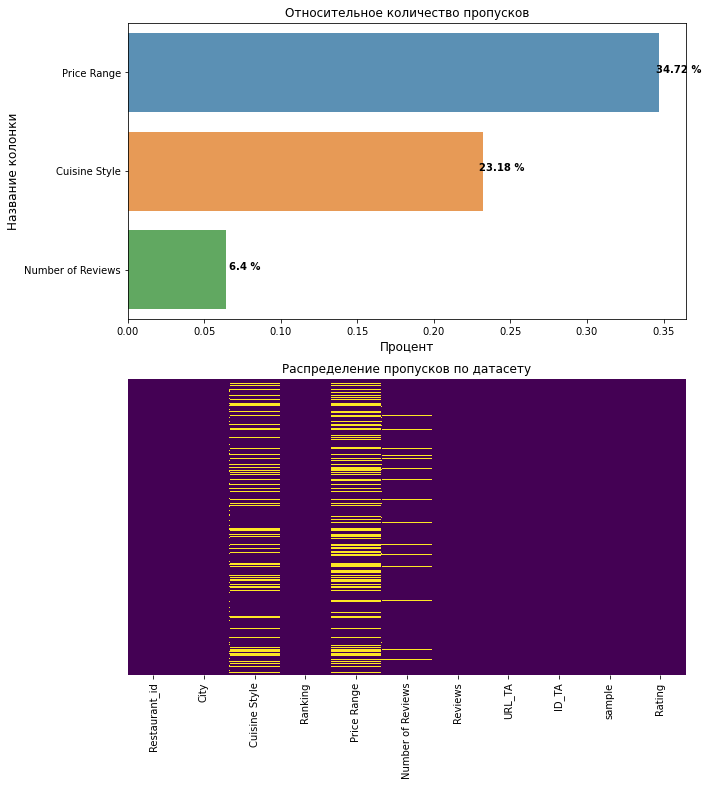

In [398]:
data_w.per_none()

Наибольшее количество пропусков в колонке Price Range. Пропуски распределены равномерно, нет какой-то явной концентрации.

#### Restaurant_id - порядковый номер ресторана

In [399]:
data.loc[:, ['Restaurant_id']].info()
data.Restaurant_id.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Restaurant_id  50000 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


id_227      19
id_633      19
id_871      19
id_436      19
id_534      18
            ..
id_14370     1
id_16039     1
id_8253      1
id_9412      1
id_9667      1
Name: Restaurant_id, Length: 13094, dtype: int64

Нет пропусков, но есть повторяющиеся значения - можно сделать вывод что это сеть ресторанов. Можно добавить новый признак является ли ресторан частью сети или нет.

#### City

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64
##########################################
Всего городов в датасете представлено - 31
##########################################


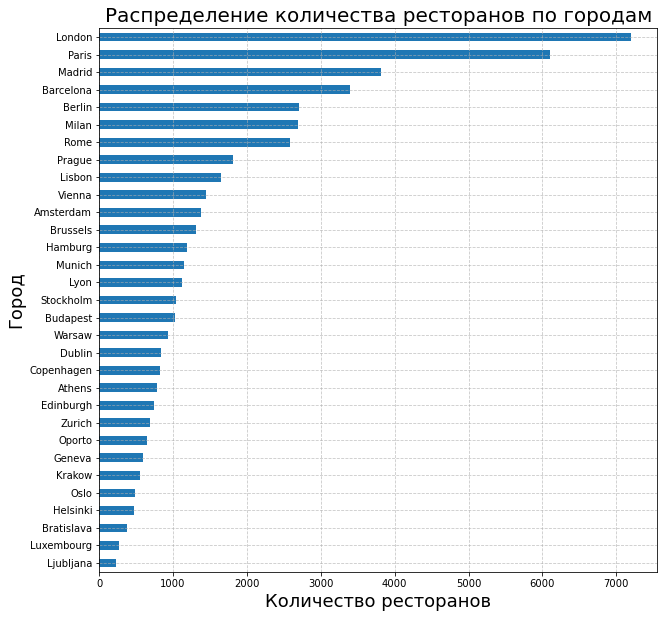

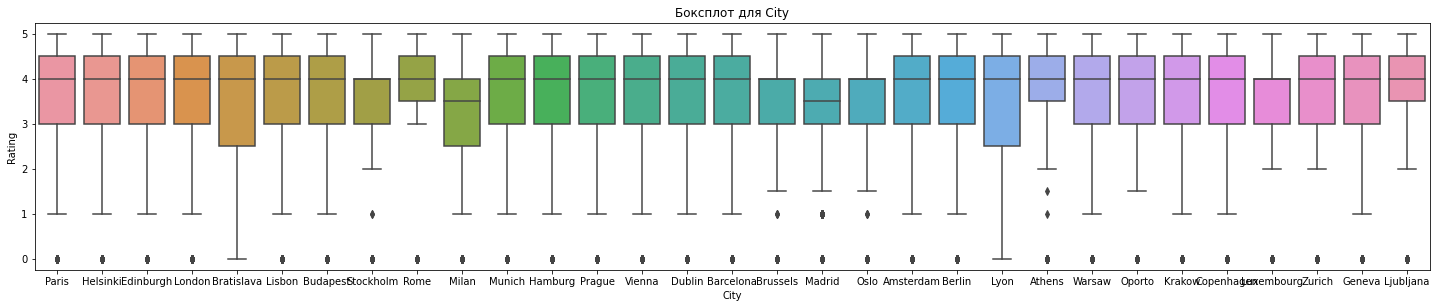

In [400]:
data_w.city_info()
data_w.draw_bp('City')

Пропусков нет. Всего в датасете представлен 31 город. Медиана по рейтингу в городах почти одинаковая. Низкий рейтинг (исключая 0) является допустимым выбросом.

На основе этого признака можно создать дополнительные. Одним из них будет признак Pop - Количество населения города  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Pop                50000 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB
None
Корреляция целевой переменной с признаком
          Rating       Pop
Rating  1.000000 -0.004963
Pop    -0.004963  1.000000


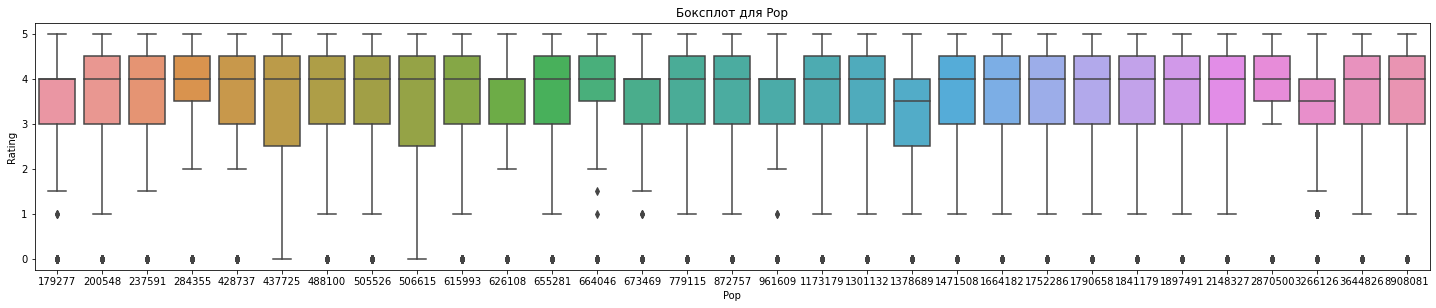

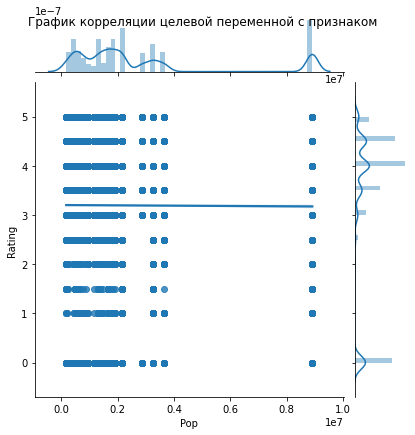

In [401]:
data_w.city_to_pop()
data_w.draw_bp('Pop', reg=True)

#### Cousine Style - виды кухни которые предствлены в ресторане

In [402]:
data_w.cuisine_info()

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object
##########################################
Пустых значений - 11590
##########################################
Всего в датасете представлено 125 кухонь
##########################################
Пустые значения переименованы в "Unknown"
##### Топ типов кухонь в ресторанах ###### 
Vegetarian Friendly    14021
European               12561
Unknown                11590
Mediterranean           7820
Italian                 7433
                       ...  
Yunnan                     2
Burmese                    1
Xinjiang                   1
Latvian                    1
Salvadoran                 1
Name: Cuisine Style, Length: 126, dtype: int64


На основе этого признака создадим дополнительные. Пустые значения заменим на список из 2х самых популярных кухонь  "European" и "Vegetarian Friendly". Более того в датасете седержатся только города Европы и европейская кухня как обощающая подходит идеально. 

In [403]:
data_w.cuisine_fill_null()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Pop                50000 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB
None


#### Price Range

In [404]:
data_w.price_range_info()

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object
##########################################
$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64
##########################################
Пустых значений - 17361


Есть пропуски - заполним наиболее частым значением - Средним ценовым сигментом.

Признак Price Range - порядковый категориальный признак. Закодируем его методом replace() как:

- \$ - низкий ценовой сегмент стоимость = 1


- \$\$ - средний ценовой сегмент = 2 


- \$$\$$ - высокий ценовой сегмент = 3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        50000 non-null  int64  
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Pop                50000 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 4.6+ MB
None
Корреляция целевой переменной с признаком
               Rating  Price Range
Rating       1.000000    -0.012176
Price Range -0.012176     1.000000


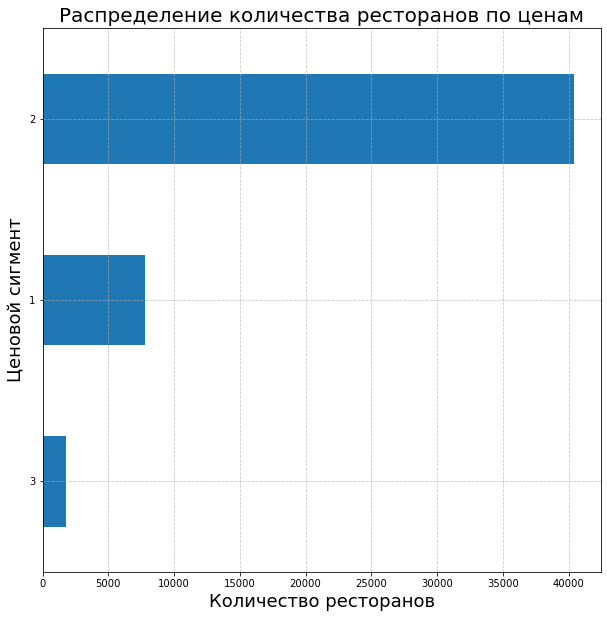

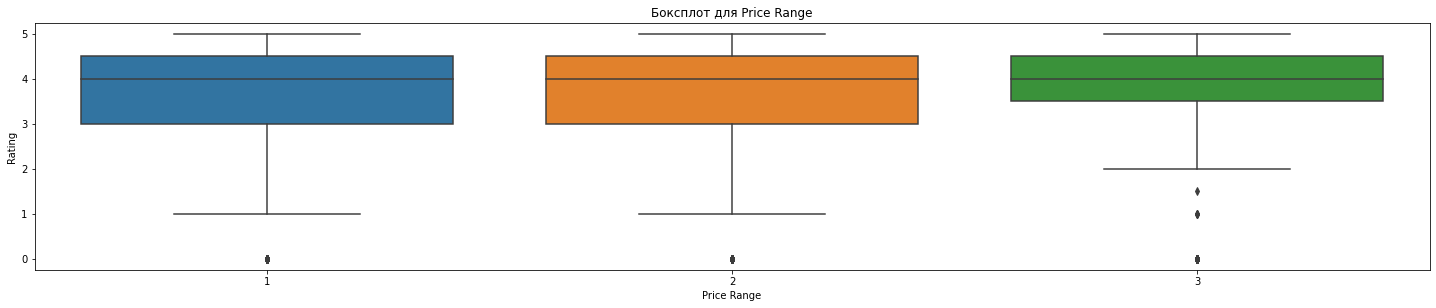

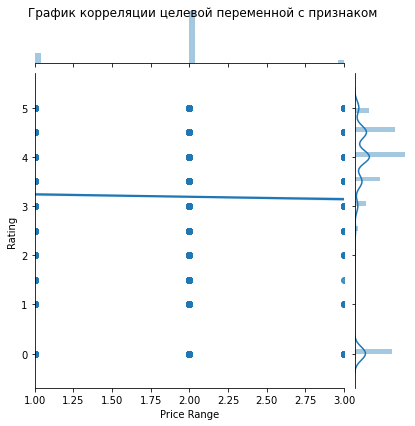

In [405]:
data_w.repair_price_range()
data_w.draw_bp('Price Range', reg=True)

Анализируя боксплот можно сказать, что в ресторанах с высокой ценой более высокий порог самого низкого отзыва, а значения меньше 2 вообще считаются выбросами. Но в данном случае допустимыми.

####  Number of Reviews


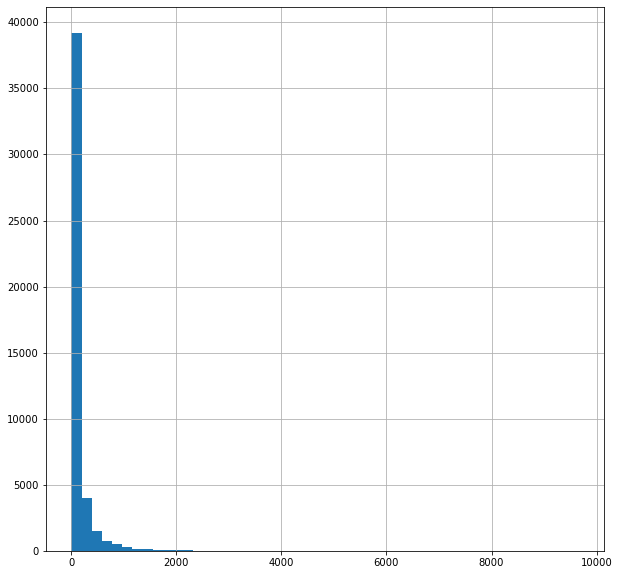

In [406]:
# Распределение признака
display(data['Number of Reviews'].hist(bins=50))

Большинство ресторанов имеют небольшое количество отзывов. Посмотрим как распределены отзывы по городам.

Пустых значений - 3200


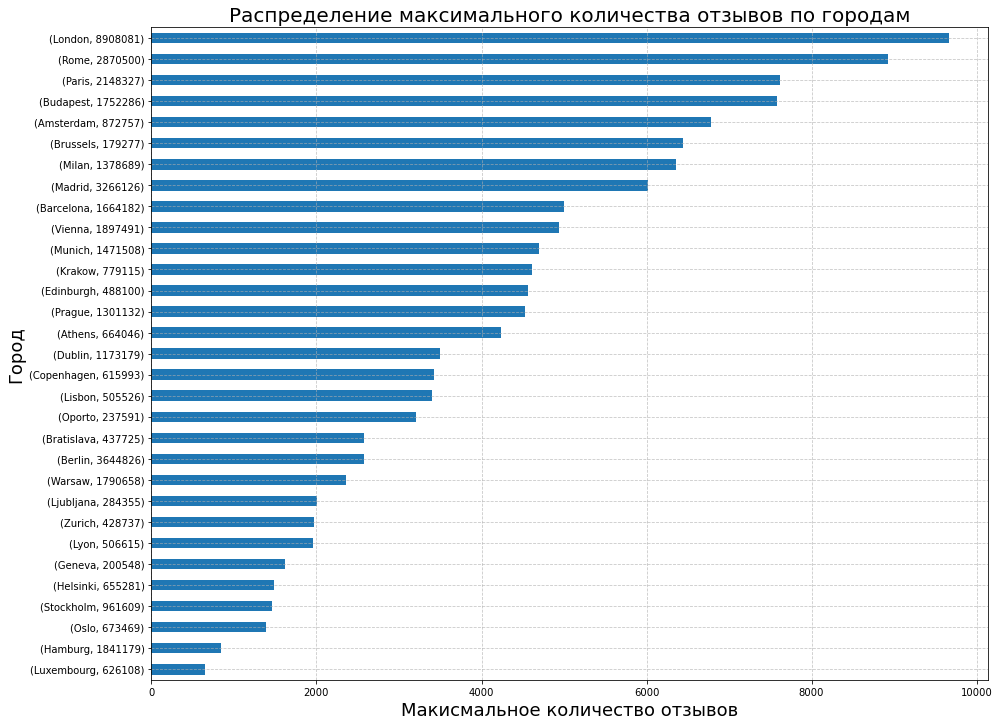

In [407]:
data_w.num_of_reviews_info()

Пустые значения могут означать отсутствие отзывов. Это было бы точно верно, если бы также отсутсвовали значения и в самих отзывах. Но кроме таких случаев, есть строки где нет количества отзывов, а тексты и даты отзывов присутсвуют и наоборот. Попробуем сделать следующим образом. Те строки, где отсутсвует и количество отзывов и сам отзыв, заменим на 0 - Отзывов нет.

Остальные отсуствующие значения заменим средним значением.

In [408]:
data_w.repair_num_of_reviews()

Количество пропусков до замены - 3200
Количество пропусков после замены - 1176
##########################################
Далее замена медианой
##########################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      50000 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        50000 non-null  int64  
 5   Number of Reviews  50000 non-null  float64
 6   Reviews            50000 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
 11  Pop                50000 non-null  int64  
dtypes: float64(3), int64(3), ob

#### Reviews

In [409]:
data_w.reviews_info()

Количество пустых значений - 8114 (Пустые строки, а не Nan)


Вытащим из этотого признака дату, и приведем ее к формату datetime

In [410]:
data_w.reviews_to_date()

Самая свежая дата 2018-02-26 00:00:00
Самая первая дата 2004-04-21 00:00:00
Количество дней между свежей и самой первой датой 3296 days 00:00:00


Пустые строки оставим. Изменим это при создании дополнительного признака

#### URL_TA и ID_TA

In [411]:
data['URL_TA'].describe() # предствляет собой страницы ресторанов с трипэдвайзера - в модели учавствовать не будет (хотя интересно что есть повторяющееся значения) 

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d987900-Reviews-Com...
freq                                                      2
Name: URL_TA, dtype: object

In [412]:
data['ID_TA'].describe() # предствляет собой ID ресторана на том же самом сайте - в модели учавствовать не будет 

count         50000
unique        49963
top       d11698990
freq              2
Name: ID_TA, dtype: object

#### Ranking 

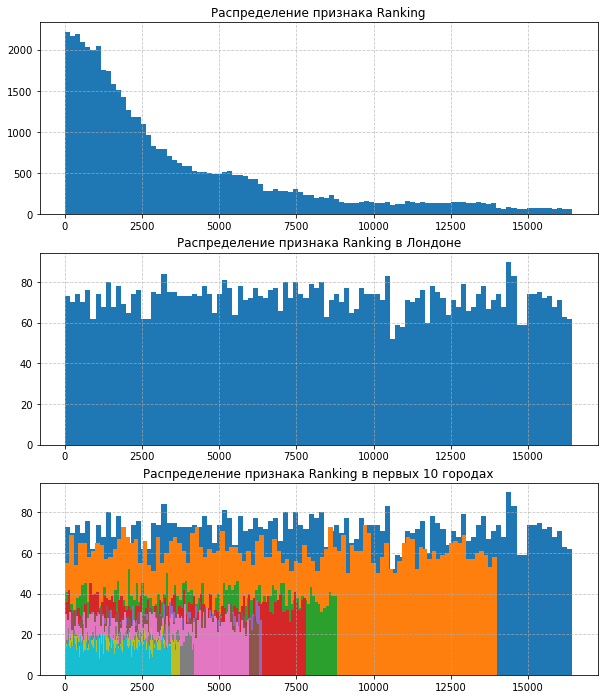

In [413]:
data_w.ranking_info()

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе. Признак Ranking зависит от количества ресторанов в городе, а следовательно, от размера города, который в нашем случае определяется по количеству населения. Далее обработаем этот признак и превратим его в порядковую категоральную переменную.



### Посмотрим распределение целевой переменной

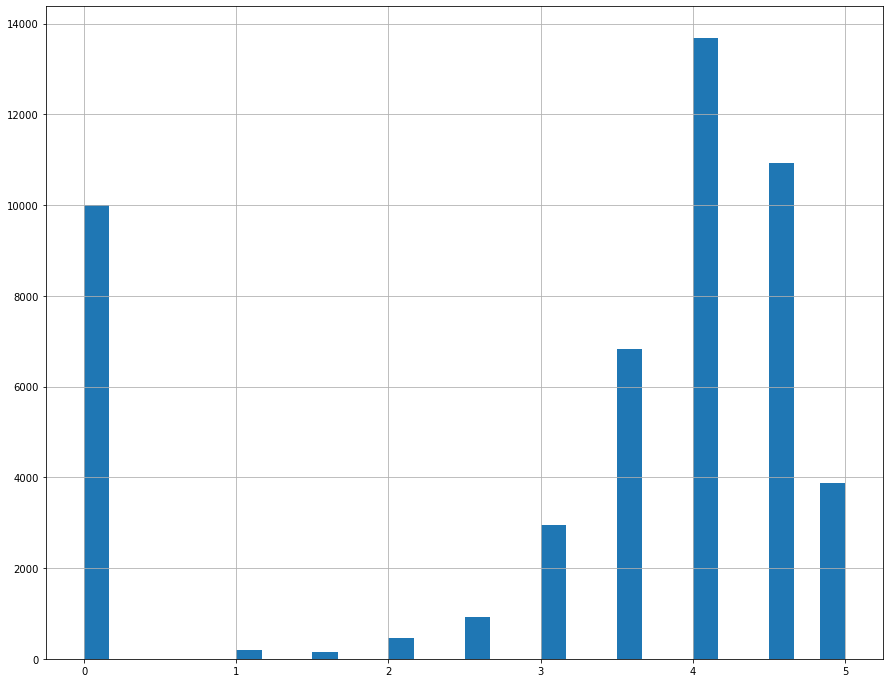

In [414]:
data['Rating'].hist(bins=30)

Не учитывая 0, целевая переменная имеет отрицательное распределение.

### Корреляция признаков до создания новых (кроме Pop)


,Ranking,Price Range,Number of Reviews,Rating,Pop
Ranking,1.000000,-0.026334,-0.221929,-0.109897,0.567760
Price Range,-0.026334,1.000000,0.108218,-0.012176,-0.017115
Number of Reviews,-0.221929,0.108218,1.000000,0.011158,0.024141
Rating,-0.109897,-0.012176,0.011158,1.000000,-0.004963
Pop,0.567760,-0.017115,0.024141,-0.004963,1.000000


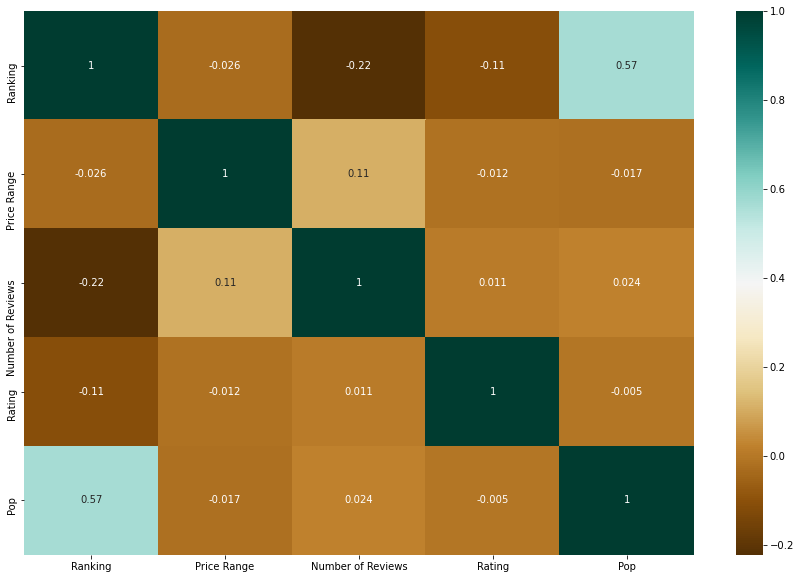

In [415]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap="BrBG", annot=True)
data.drop(['sample'], axis=1).corr()

Из графика следует, что из имеющихся у нас данных, бОльшая коррелиция у целевой переменной с признаком Ranking. 
Интресно, что Ranking давольно сильно коррелирует с признаком Pop. Это однако объяснимо тем, что в больших городах больше ресторанов и следовательно максимальный ранг(место среди других) ресторана имеет большее значение. 

In [416]:
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Pop,review_date,review_date_1,review_date_2
20095,id_1165,Copenhagen,"[European, Vegetarian Friendly]",1159.0,2,29.0,"[['Best COFFEE'], ['03/13/2015']]",/Restaurant_Review-g189541-d4888776-Reviews-Be...,d4888776,1,5.0,615993,[03/13/2015],2015-03-13,NaT
14523,id_3905,London,"[European, Portuguese, Vegetarian Friendly]",3912.0,2,166.0,"[['a good Nandos', 'A very reasonable lunch'],...",/Restaurant_Review-g186338-d3267248-Reviews-Na...,d3267248,1,4.0,8908081,"[11/06/2017, 10/17/2017]",2017-11-06,2017-10-17
48694,id_213,Dublin,"[Irish, Bar, European, Pub, Gastropub, Vegetar...",214.0,2,274.0,"[['Pre-Wedding Dinner for 60', 'Lovely staff']...",/Restaurant_Review-g186605-d811299-Reviews-The...,d811299,1,4.5,1173179,"[01/04/2018, 12/28/2017]",2018-01-04,2017-12-28


<a id='4'> <a/>
# Feature Engineering

In [417]:
# на всякий случай, заново подгружаем данные
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#data.info()

In [418]:
#def preproc_data(df_input):
#'''includes several functions to pre-process the predictor data.'''
    
    #df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    #df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    #df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    #object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    #df_output.drop(object_columns, axis = 1, inplace=True)
    
    #return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

In [419]:
# Создание признака является ли ресторан частью сети рестоарнов или нет
restaurant_chain = data['Restaurant_id'].value_counts()[data['Restaurant_id'].value_counts()>1].index.tolist()
data['Restaurant_chain'] = data[data['Restaurant_id'].isin(restaurant_chain)].Restaurant_id.apply(lambda x: 1) 
data['Restaurant_chain'] = data['Restaurant_chain'].fillna(0) 
data['Restaurant_chain'].describe()

count    50000.000000
mean         0.923860
std          0.265225
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Restaurant_chain, dtype: float64

In [420]:
# Создание новых признаков на основе признака City
help(data_w.new_feat_city)
data_w.new_feat_city()

Help on method new_feat_city in module __main__:

new_feat_city() method of __main__.TadRating instance
    Метод создает новые признаки:
    1 - country - в какой стране город
    2 - is_capiral - является ли город столицей (да/нет)
    3 - pop_cat - категория города относительно населения



In [421]:
# Создание новых признаков на основе признака Cuisine Style
help(data_w.new_feat_cuisine)
data_w.new_feat_cuisine()

Help on method new_feat_cuisine in module __main__:

new_feat_cuisine() method of __main__.TadRating instance
    Метод создает новые признаки:
    1 - poly_cuisine - количество уникальных кухонь в ресторанах каждого города.
    2 - local_cuisine - есть ли в ресторане местаня кухня (да/нет)
    3 -

0    32964
1    17036
Name: local_cuisine, dtype: int64
Большинство ресторанов не имеют местной кухни


In [422]:
help(data_w.per_city_mean)
data_w.per_city_mean()

Help on method per_city_mean in module __main__:

per_city_mean() method of __main__.TadRating instance
    Метод создающий признак среднее количество отзывов в городе.



In [423]:
help(data_w.new_feat_reviews)
data_w.new_feat_reviews()

Help on method new_feat_reviews in module __main__:

new_feat_reviews() method of __main__.TadRating instance
    Метод создает признак review_day_freq. Как часто оставляют отзывы в ресторане. 
    Пустые значения заполним 0.



Согласно карте корреляций признак Ranking имеет обратную корреляцию с целевой переменной Rating. Значит, чем больше номер позиции ресторана в городе, тем меньше рейтинг. 

Предположим, что номер позиции Ranking прикрепляется к ресторану не навсегда, а меняется в зависимости от каких-то других факторов. Тогда ресторан может двигаться в некотором диапазоне Ranking в своем городе. 
Попробуем перевести признак Ranking в порядковую категориальную переменную разбив ее на 5 интервалов («Топовый», «высокий», «средний», «ниже среднего», «низкий»), где:
- 5 - Топовый
- ...
- 1 - Низкий
- 0 - Нет ранга

- При этом 5<4<3<2<1 

Однако, стоит учесть, что в маленьких городах ресторанов в принципе меньше, чем в больших. А значит, например интервал «высокого» ранга в маленьком городе будет отличаться от аналогичного ранга в больших городах. 

Поэтому данный признак должен быть собственный для каждой группы городов. В нашем случае таких групп – 3. 


In [424]:
help(data_w.new_feat_ranking)
data_w.new_feat_ranking()

Help on method new_feat_ranking in module __main__:

new_feat_ranking() method of __main__.TadRating instance
    Перевод признака Ranking в порядковую категориальную переменную,
    
    группировкой ее на 5 интервалов, с учетом количества населенияв городе
    
    («Топовый», «высокий», «средний», «ниже среднего», «низкий»), где:
    - 5 - Топовый
    - ...
    - 1 - Низкий
    - 0 - Нет ранга
    - При этом 5<4<3<2<1 
    
    На выходе + 3 колонки:
    - 'Big_City_Rank'
    - 'Mid_City_Rank'
    - 'Lit_City_Rank'



Просмотрим корреляцию по датасету (до создания dummy-переменных)

,Ranking,Price Range,Number of Reviews,Rating,Pop,Restaurant_chain,Is_capital,poly_cuisine,local_cuisine,NoF_per_city_mean,review_day_freq,Big_City_Rank,Mid_City_Rank,Lit_City_Rank
Ranking,1.000000,-0.026334,-0.221929,-0.109897,0.567760,-0.502592,0.181705,0.648816,-0.118403,0.103818,0.069228,0.622084,0.327864,-0.289449
Price Range,-0.026334,1.000000,0.108218,-0.012176,-0.017115,0.005652,-0.001083,0.013940,-0.004418,-0.086122,-0.035108,-0.035361,0.019523,-0.026815
Number of Reviews,-0.221929,0.108218,1.000000,0.011158,0.024141,0.061363,0.009373,0.003537,0.220350,0.177588,-0.088623,-0.086520,-0.098071,-0.107308
Rating,-0.109897,-0.012176,0.011158,1.000000,-0.004963,0.150831,0.010428,-0.014275,0.010372,0.016814,-0.025971,-0.028778,-0.030873,-0.043089
Pop,0.567760,-0.017115,0.024141,-0.004963,1.000000,-0.286427,0.293057,0.757609,-0.070416,0.135937,-0.017935,0.817430,-0.169973,-0.464340
Restaurant_chain,-0.502592,0.005652,0.061363,0.150831,-0.286427,1.000000,-0.109300,-0.260598,0.070503,-0.029264,-0.040213,-0.286538,-0.096198,0.130055
Is_capital,0.181705,-0.001083,0.009373,0.010428,0.293057,-0.109300,1.000000,0.267854,-0.066823,0.052777,-0.003167,0.326481,-0.144275,-0.161497
poly_cuisine,0.648816,0.013940,0.003537,-0.014275,0.757609,-0.260598,0.267854,1.000000,-0.029680,0.019919,0.001875,0.560940,0.282503,-0.509311
local_cuisine,-0.118403,-0.004418,0.220350,0.010372,-0.070416,0.070503,-0.066823,-0.029680,1.000000,0.210589,-0.029672,-0.083987,0.015532,-0.056870
NoF_per_city_mean,0.103818,-0.086122,0.177588,0.016814,0.135937,-0.029264,0.052777,0.019919,0.210589,1.000000,-0.038934,0.163056,-0.112393,0.022173


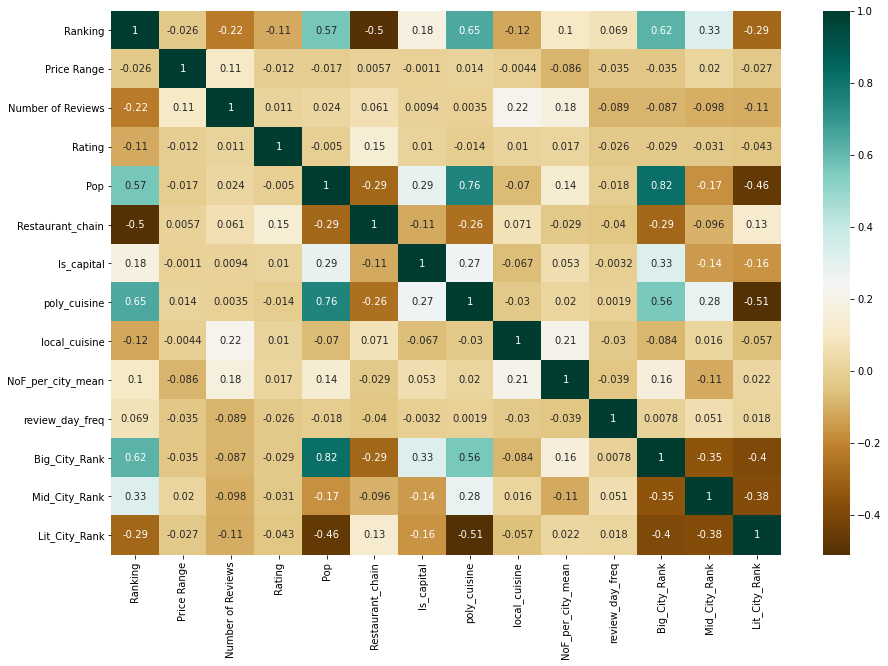

In [425]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap="BrBG", annot=True)
data.drop(['sample'], axis=1).corr()

Рейтинг очень слабо коррелирует с признаком цены обслуживания и частотой оставлния отзывов. 

Создание dummy-переменных.
Разложим признак City и признак Cuisine Style в колонки (да/нет)

In [426]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=False)

In [427]:
mlb = MultiLabelBinarizer()
data_cuisine = pd.DataFrame(mlb.fit_transform(data['Cuisine Style']), columns=mlb.classes_)
data = pd.concat([data, data_cuisine], axis=1)


In [428]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 181 entries, Restaurant_id to Yunnan
dtypes: category(1), datetime64[ns](2), float64(9), int32(125), int64(6), object(7), uint8(31)
memory usage: 34.5+ MB


#### Запускаем и проверяем что получилось

In [429]:
#df_preproc = preproc_data(data)
#df_preproc.sample(10)

In [430]:
#df_preproc.info()

In [431]:
data.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop(['review_date_1', 'review_date_2'],axis=1, inplace=True)

In [432]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 172 entries, Ranking to Yunnan
dtypes: category(1), float64(9), int32(125), int64(6), uint8(31)
memory usage: 31.1 MB


In [433]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [434]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [435]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (32000, 170), (8000, 170))

# Model 
Сам ML

In [436]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [437]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [438]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [439]:
def round_rating_pred(rating_pred):
    if rating_pred <= 0.25:
        return 0.0
    if rating_pred <= 0.75:
        return 0.5
    if rating_pred <= 1.25:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0


# Round it
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [440]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.179625


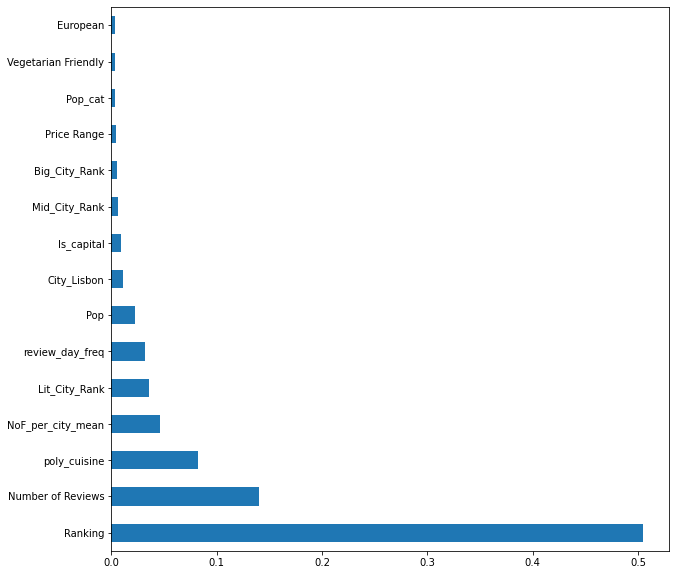

In [441]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Интересно, что признак poly_cuisine (сколько всего уникальных типо кухонь представлено в городе) на 3 месте по значимости. 

# Submission
Если все устраевает - готовим Submission на кагл

In [442]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Pop,Restaurant_chain,Is_capital,Pop_cat,poly_cuisine,local_cuisine,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
9530,2705.0,2,4.0,0.0,1471508,0.0,0,2,77,0,...,0,0,0,1,0,0,0,0,0,0
5200,4493.0,2,6.0,0.0,3644826,1.0,1,3,98,0,...,0,0,0,0,0,0,0,0,0,0
7733,253.0,2,228.0,0.0,505526,1.0,1,1,73,0,...,0,0,1,1,0,0,0,0,0,0
2107,302.0,3,241.0,0.0,179277,1.0,1,1,80,0,...,0,0,1,1,0,0,0,0,0,0
9486,2028.0,2,7.0,0.0,179277,0.0,1,1,80,0,...,0,0,0,0,0,0,0,0,0,0
5103,2718.0,2,9.0,0.0,1301132,1.0,1,1,82,0,...,0,0,0,1,0,0,0,0,0,0
5611,2078.0,2,2.0,0.0,1790658,1.0,1,2,74,0,...,0,0,0,1,0,0,0,0,0,0
759,4914.0,2,8.0,0.0,2870500,1.0,1,3,80,0,...,0,0,0,1,0,0,0,0,0,0
562,13021.0,2,4.0,0.0,2148327,1.0,1,2,102,0,...,0,0,0,0,0,0,0,0,0,0
4454,186.0,2,32.0,0.0,284355,1.0,1,1,55,0,...,0,0,0,0,0,0,0,0,0,0


In [443]:
test_data = test_data.drop(['Rating'], axis=1)

In [444]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [445]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [446]:
predict_submission

array([3.02 , 4.225, 4.56 , ..., 3.   , 4.48 , 4.135])

In [447]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission_1.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.225
2,id_2,4.560
3,id_3,4.345
4,id_4,4.495
5,id_5,4.430
6,id_6,1.375
7,id_7,2.700
8,id_8,4.295
9,id_9,4.685


# Вопросы ментору


1. В какой последовательности следует проводить такие работы? Т.е. нужно сперва от начала доконца проводить анализ, а уже потом заниматься созданием новых признаков или это не имеет значения? 

2. Если мы создали какой-то новый признак, проверили и оказалось он не подходит, нужно ли оставлять ход действий или главное уже предоставить окончательную версию?

3. Нужно ли удалять признаки, которые не попали в топ по значимости? 

4. Как понять, что мы достигли оптимального значения MAE. Например если работа ведется не на соревновании, а это рабочая задача. Как понять, что мы создали слишком много признаков и больше не надо. Или это уже вопрсы переобучения модели?